## Filter - 1

In [2]:
!python3 --version
import epics
import numpy
import pandas
import torch

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

torch.set_printoptions(precision=16, sci_mode=True)
print(torch.__version__)
print(torch.cuda.is_available())

Python 3.8.10
1.9.0+cpu
False


In [98]:
"""
Filter & process TbT data.
Noise estimation.

"""
class Filter():
    
    def __init__(self, data:'Data'=None) -> None:
        self.data = data
        
        
        self.sigma = None
        self.rank = None
        
        
    @staticmethod
    @torch.jit.script
    def make_matrix(signal:torch.Tensor) -> torch.Tensor:
        """
        Compute matrix representation (Hankel matrix) for a given batch of signals.
        If signal length is 2*n, output matrix shape is (n + 1, n).
        
        """
        size, length = signal.shape
        length = length // 2
        matrix = torch.zeros((size, length + 1, length), dtype=signal.dtype, device=signal.device)
        for i in range(length + 1):
            matrix[:, i].copy_(signal[:, i:i + length])
        return matrix
    
    
    @staticmethod
    @torch.jit.script
    def make_signal(matrix:torch.Tensor) -> torch.Tensor:
        """
        Compute signal representation for a given batch of (Hankel) matrices.
        If matrix shape is (n + 1, n), output signal length is 2*n.
        
        """
        matrix = torch.transpose(matrix, 1, 2).flip(1)
        size, length, _ = matrix.shape
        signal = torch.zeros((size, 2*length), dtype=matrix.dtype, device=matrix.device)
        for i, j in enumerate(range(-length + 1, length + 1)):
            signal[:, i] = torch.mean(torch.diagonal(matrix, dim1=1, dim2=2, offset=j), 1)
        return signal
    
    
    @staticmethod
    @torch.jit.script
    def sigma(matrix:torch.Tensor, cpu:bool=True) -> tuple:
        """
        Estimate noise sigma and rank for a given batch of matrices.
        
        """
        size, m, n = matrix.shape
        data = torch.linalg.svdvals(matrix.cpu() if cpu else matrix).to(matrix.device)
        median = torch.median(data, dim=-1).values
        beta = torch.tensor(min(m, n)/max(m, n), dtype=matrix.dtype, device=matrix.device)
        omega = 0.56*beta**3 - 0.95*beta**2 + 1.82*beta + 1.43
        psi = torch.sqrt(2*(beta + 1) + 8*beta/(beta + 1 + torch.sqrt(beta**2 + 14*beta + 1)))
        tau = omega*median
        factor = torch.sqrt(torch.tensor(max(m, n), dtype=matrix.dtype, device=matrix.device))
        return tau/psi/factor, torch.sum((data - tau.reshape(-1, 1) > 0), 1)
    
    
    @staticmethod
    @torch.jit.script
    def svd_val(matrix:torch.Tensor, cpu:bool=True) -> torch.Tensor:
        """
        Compute singular values for a given batch of matrices.
        
        """
        return torch.linalg.svdvals(matrix.cpu() if cpu else matrix).to(matrix.device)
    
    
    @staticmethod
    @torch.jit.script
    def svd_cut(rank:torch.Tensor, matrix:torch.Tensor, cpu:bool=True) -> torch.Tensor:
        """
        Compute svd truncation for given list of ranks and a batch of matirices.
        
        """
        u, s, v = torch.linalg.svd(matrix.cpu() if cpu else matrix, full_matrices=False)
        u.to(matrix.device)
        s.to(matrix.device)
        v.to(matrix.device)
        for i, rank in enumerate(rank):
            s[i, rank:] = 0.0
        return torch.matmul(torch.matmul(u, torch.diag_embed(s)), v)
    
    
    def noise(self, *, size:int=64, cpu:bool=True) -> None:
        """
        Estimate noise sigma and rank for given TbT data.
        
        """
        self.sigma, self.rank = self.__class__.sigma(
            self.__class__.make_matrix(self.data.data)[:, :size], cpu=cpu)
        

        
    ####
    #### Do separate methods for full TbT svd clean (given or optimal), hankel, rpca (full or individual), ica?
    #### rpca + hankel (decomposition), hankel as decomposition?
    #### decomposition and cleaning functions
    
    def clean(self, *, mode:str='SVD', rank:int=0) -> None:
        """
        Perform TbT cleaning.
        'SVD' -- SVD truncation of full TbT matrix for given rank (int)
        
        """
        # mode   -- all
        # method -- svd, hankel, rpca, hankel+rpca, ica
            
    
    
    
win = Window(512, dtype=torch.float64, device='cpu')
tim = torch.linspace(1, len(win), len(win), dtype=win.dtype, device=win.device)
dat = torch.stack([torch.sin(2*numpy.pi*0.12*tim) + 0.1*torch.sin(2*numpy.pi*2*0.12*tim) for _ in range(64)])
std = 0.001
err = std*torch.randn(len(win), dtype=win.dtype, device=win.device)
dat += err
tbt = Data.from_tensor(win, dat)
fil = Filter(tbt)
fil.noise()

tensor(1.5836897492474352e-02, dtype=torch.float64)


In [64]:
res = Filter.svd_cut(torch.LongTensor([2, 4, 6, 8]), mat)
torch.linalg.matrix_rank(res)

tensor([2, 2, 2, 2])

In [82]:
%%time
out = Filter.sigma(mat[:, :64, :])
print(out[0][0]-std)
print(out[1][0])

tensor(-9.9999999999989529e-04, dtype=torch.float64)
tensor(19)
CPU times: user 11.8 ms, sys: 3.98 ms, total: 15.8 ms
Wall time: 10.5 ms


In [37]:
win = Window(512, dtype=torch.float64, device='cpu')
tim = torch.linspace(1, len(win), len(win), dtype=win.dtype, device=win.device)
dat = torch.stack([torch.sin(2*numpy.pi*0.12*tim) + 0.1*torch.sin(2*numpy.pi*2*0.12*tim) for _ in range(4)])
std = 0.001
err = std*torch.randn(len(win), dtype=win.dtype, device=win.device)
dat += err
mat = Filter.make_matrix(dat)
sig = Filter.make_signal(mat)

In [ ]:
# svd value
# svd truncation (optimal)
# filter

In [ ]:
win = Window(512, dtype=torch.float64, device='cuda')
tim = torch.linspace(1, len(win), len(win), dtype=win.dtype, device=win.device)
dat = torch.stack([torch.sin(2*numpy.pi*0.12*tim) + 0.1*torch.sin(2*numpy.pi*2*0.12*tim) for _ in range(64)])
err = torch.randn(len(win), dtype=win.dtype, device=win.device)
dat += err
dat.device

In [ ]:
torch.cuda.empty_cache()

In [175]:
win = Window(1024, dtype=torch.float64, device='cpu')
tim = torch.linspace(1, len(win), len(win), dtype=win.dtype, device=win.device)
dat = torch.stack([torch.sin(2*numpy.pi*0.12*tim) + 0.1*torch.sin(2*numpy.pi*2*0.12*tim) for _ in range(4)])
std = 0.01
err = std*torch.randn(len(win), dtype=win.dtype, device=win.device)
dat += err
mat = Filter.make_matrix(dat)
mat = Filter.svd_cut(torch.LongTensor([2, 2, 2, 2]), mat)
sig = Filter.make_signal(mat)

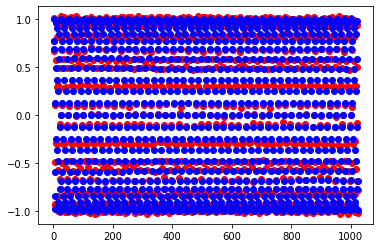

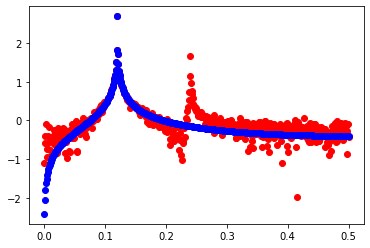

In [68]:
import matplotlib.pyplot as plt
plt.scatter(tim, dat[0], c='r')
plt.scatter(tim, sig[0], c='b')
plt.show()

plt.scatter(torch.fft.rfftfreq(win.length), torch.log10(torch.abs(torch.fft.rfft(dat[0]))), c='r')
plt.scatter(torch.fft.rfftfreq(win.length), torch.log10(torch.abs(torch.fft.rfft(sig[0]))), c='b')
plt.show()

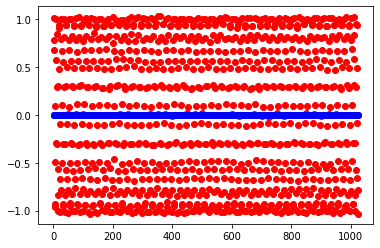

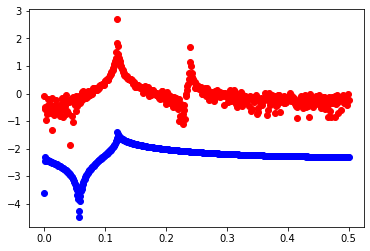

In [204]:
from sklearn.decomposition import FastICA
X = mat[1]
ica = FastICA(n_components=4)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_           # Get estimated mixing matrix
tmp = np.dot(S_, A_.T) + ica.mean_
tmp = Filter.make_signal(torch.tensor([tmp]))[0]

plt.scatter(tim, dat[0], c='r')
plt.scatter(tim, tmp, c='b')
plt.show()

plt.scatter(torch.fft.rfftfreq(win.length), torch.log10(torch.abs(torch.fft.rfft(dat[1]))), c='r')
plt.scatter(torch.fft.rfftfreq(win.length), torch.log10(torch.abs(torch.fft.rfft(tmp))), c='b')
plt.show()

## Filter - 0

In [ ]:
import epics
import numpy
import pandas
import torch

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

torch.set_printoptions(precision=16, sci_mode=True)
torch.cuda.is_available()

In [ ]:
pv_list = ["VEPP4:STP2:turns_x-I", "VEPP4:STP4:turns_x-I", "VEPP4:SRP1:turns_x-I", "VEPP4:SRP2:turns_x-I", "VEPP4:SRP3:turns_x-I", "VEPP4:SRP4:turns_x-I", "VEPP4:SRP5:turns_x-I", "VEPP4:SRP6:turns_x-I", "VEPP4:SRP7:turns_x-I", "VEPP4:SRP8:turns_x-I", "VEPP4:SRP9:turns_x-I", "VEPP4:SIP1:turns_x-I", "VEPP4:SIP2:turns_x-I", "VEPP4:SRP10:turns_x-I", "VEPP4:SRP11:turns_x-I", "VEPP4:SRP12:turns_x-I", "VEPP4:SRP13:turns_x-I", "VEPP4:SRP14:turns_x-I", "VEPP4:SRP15:turns_x-I", "VEPP4:SRP16:turns_x-I", "VEPP4:SRP17:turns_x-I", "VEPP4:SEP5:turns_x-I", "VEPP4:SEP4:turns_x-I", "VEPP4:SEP3:turns_x-I", "VEPP4:SEP1:turns_x-I", "VEPP4:SEP0:turns_x-I", "VEPP4:NEP0:turns_x-I", "VEPP4:NEP1:turns_x-I", "VEPP4:NEP3:turns_x-I", "VEPP4:NEP4:turns_x-I", "VEPP4:NEP5:turns_x-I", "VEPP4:NRP17:turns_x-I", "VEPP4:NRP16:turns_x-I", "VEPP4:NRP15:turns_x-I", "VEPP4:NRP14:turns_x-I", "VEPP4:NRP13:turns_x-I", "VEPP4:NRP12:turns_x-I", "VEPP4:NRP11:turns_x-I", "VEPP4:NRP10:turns_x-I", "VEPP4:NIP3:turns_x-I", "VEPP4:NIP1:turns_x-I", "VEPP4:NRP9:turns_x-I", "VEPP4:NRP8:turns_x-I", "VEPP4:NRP7:turns_x-I", "VEPP4:NRP6:turns_x-I", "VEPP4:NRP5:turns_x-I", "VEPP4:NRP4:turns_x-I", "VEPP4:NRP3:turns_x-I", "VEPP4:NRP2:turns_x-I", "VEPP4:NRP1:turns_x-I", "VEPP4:NTP4:turns_x-I", "VEPP4:NTP2:turns_x-I", "VEPP4:NTP0:turns_x-I", "VEPP4:STP0:turns_x-I"]
pv_rise = [0 for _ in range(len(pv_list))]

win = Window(1024, dtype=torch.float64, device='cpu')
tbt = Data.from_epics(54, win, pv_list, pv_rise)

In [ ]:
"""
Filter & process TbT data

"""
class Filter():
    
    def __init__(self, data:'Data'=None) -> None:
        self.data = data
    
    
#     @staticmethod
#     @torch.jit.script
#     def make_matrix(signal:torch.Tensor) -> torch.Tensor:
#         size, length = signal.shape
#         length = length // 2
#         matrix = torch.zeros((size, length + 1, length), dtype=signal.dtype, device=signal.device)
#         for i in range(length + 1):
#             matrix[:, i].copy_(signal[:, i:i + length])
#         return matrix

    @staticmethod
    @torch.jit.script
    def make_matrix(signal:torch.Tensor) -> torch.Tensor:
        size, length = signal.shape
        length = length // 2
        matrix = torch.zeros((size, length, length), dtype=signal.dtype, device=signal.device)
        for i in range(length):
            matrix[:, i].copy_(signal[:, i:i + length])
        return matrix
    
    
    @staticmethod
    @torch.jit.script
    def make_signal(matrix:torch.Tensor) -> torch.Tensor:
        matrix = torch.transpose(matrix, 1, 2).flip(1)
        size, length, _ = matrix.shape
        signal = torch.zeros((size, 2*length), dtype=matrix.dtype, device=matrix.device)
        for i, j in enumerate(range(-length + 1, length + 1)):
            signal[:, i] = torch.mean(torch.diagonal(matrix, dim1=1, dim2=2, offset=j), 1)
        return signal
    
    
    @staticmethod
    @torch.jit.script
    def svd_list(count:int, matrix:torch.Tensor) -> torch.Tensor:
        u, s, v = torch.linalg.svd(matrix)
        size, length = s.shape
        return s[:, :min(count, length)]
    
    
    @staticmethod
    @torch.jit.script
    def svd_truncate(count:int, matrix:torch.Tensor) -> torch.Tensor:
        u, s, v = torch.linalg.svd(matrix, full_matrices=False)
        u = u[:, :, :count]
        s = torch.diag_embed(s[:, :count])
        v = v[:, :count, :]
        return torch.matmul(torch.matmul(u,s), v)
    
    # no need for static? sure no need to jit
    @staticmethod
    def svd_optimal(matrix:torch.Tensor) -> torch.Tensor:
        size, nr, nc = matrix.shape
        data = Filter.svd_list(min(nr, nc), matrix)
        median, _ = torch.median(data, 1)
        beta = min(nr/nc, nc/nr)
        lamb = numpy.sqrt(2*(beta+1) + 8*beta/(beta + 1 + numpy.sqrt(beta**2 + 14*beta + 1)))
        omega = 0.56*beta**3 - 0.95*beta**2 + 1.82*beta + 1.43
        tau = omega*median
#         print('nr', 1-tau/lamb/numpy.sqrt(nr))
#         print('nc', 1-tau/lamb/numpy.sqrt(nc))
        return tau/lamb/numpy.sqrt(nr)

In [ ]:
win = Window(512, dtype=torch.float64, device='cuda')
tim = torch.linspace(1, len(win), len(win), dtype=win.dtype, device=win.device)
dat = torch.stack([torch.sin(2*numpy.pi*0.12*tim) + 0.1*torch.sin(2*numpy.pi*2*0.12*tim) for _ in range(64)])
err = torch.randn(len(win), dtype=win.dtype, device=win.device)
dat += err
dat.device

In [ ]:
%%time
mat = Filter.make_matrix(dat)
print(mat.shape)
print(mat.device)
res = torch.linalg.svd(mat)

In [ ]:
torch.__version__

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!python --version

In [ ]:
# S$OPTIMAL$SVD$TRUNCATION[           (* -- OPTIMAL SVD TRUNCATION *)
#   MATRIX_?MatrixQ                   (* -- MATRIX WITH M < N *)
# ] := Block[
#   {NR, NC, LIST, MEDIAN, BETA, LAMBDA, OMEGA, TAU},
#   {NR, NC} = Dimensions[MATRIX] ;
#   LIST = SingularValueList[MATRIX, Min[{NR, NC}]] ;
#   MEDIAN = Median[LIST] ;
#   BETA = N[Apply[Divide, Sort[{NR, NC}]]] ;
#   LAMBDA = Sqrt[2*(BETA + 1) + 8*BETA/(BETA + 1 + Sqrt[BETA^2 + 14*BETA + 1])] ;
#   OMEGA = 0.56*BETA^3 - 0.95*BETA^2 + 1.82*BETA + 1.43 ;
#   TAU = OMEGA*MEDIAN ;
#   {Length[DeleteCases[Ramp[Subtract[LIST, TAU]], N[0]]], TAU, TAU/LAMBDA/Sqrt[N[NC]]}
# ] ;

In [ ]:
import matplotlib.pyplot as plt
mat = Filter.make_matrix(dat)
mat = Filter.svd_truncate(2, mat)
sig = Filter.make_signal(mat)
sig = sig[0]
fou = torch.abs(torch.fft.rfft(sig))
fre = torch.fft.rfftfreq(len(sig))
plt.figure(figsize=(10, 5))
plt.scatter(fre, fou)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
mat = Filter.make_matrix(dat)
mat = Filter.svd_truncate(4, mat)
sig = Filter.make_signal(mat)
sig = sig[0]
fou = torch.abs(torch.fft.rfft(sig))
fre = torch.fft.rfftfreq(len(sig))
plt.figure(figsize=(10, 5))
plt.scatter(fre, fou)
plt.show()

In [ ]:
# from sklearn.decomposition import FastICA
# transformer = FastICA(n_components=len(mat[0]), random_state=0)
# # x = transformer.fit_transform(mat[0].numpy())
# len(mat[0])

In [ ]:
# >>> from sklearn.datasets import load_digits
# >>> from sklearn.decomposition import FastICA
# >>> X, _ = load_digits(return_X_y=True)
# >>> transformer = FastICA(n_components=7,
# ...         random_state=0)
# >>> X_transformed = transformer.fit_transform(X)
# >>> X_transformed.shape
# (1797, 7)

In [ ]:
    
#     @staticmethod
#     @torch.jit.script
#     def svd_list

#     def svd

#     def make_matrix
#     def make_signal

#     def svd_optimal

## Frequency

In [ ]:
import epics
import numpy
import pandas
import torch

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency

torch.set_printoptions(precision=12, sci_mode=True)
torch.cuda.is_available()

In [ ]:
# Example-01: FFT amplitude spectrum

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set TbT data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)

# Initialize Frequency instance
f = Frequency(tbt)

# Apply window
f.data.window_apply()

# FFT frequencies are stored in fft_grid (computed on initialization)
# FFT spectrum amplitudes are stored in fft_spectrum for each signal

# Compute FFT amplitude spectrum
f.fft_get_spectrum()

# Reset TbT work
f.data.reset()

# Plot FFT spectrum for given signal id
idx = 0
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=0.5, c='b')
plt.xlim(0.1, 0.3)
plt.show()

In [ ]:
# Example-02: FFT amplitude spectrum & zero padding

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)

# If pad == 0, it is set to signal length
# Spectrum is computed using torch.fft.rfft(..., n=pad)
# Padding can be used to interpolate DTFT spectrum in all frequency range
# This improves frequency estimation accuracy (assuming frequency corresponds to max of the largest FFT spectrum amplitude peak)
# Can be used to obtain a better initial guess, if signal has several frequencies with close amplitudes

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**4)
f2 = Frequency(tbt, pad=length*2**0)

# Apply window to data
f1.data.window_apply()
f2.data.window_apply()

# Compute FFT amplitude spectrum
f1.fft_get_spectrum()
f2.fft_get_spectrum()

# Reset TbT work
f1.data.reset()
f2.data.reset()

# Plot (log10) FFT spectrum for given signal id
idx = 0
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(f1.fft_grid.detach().cpu(), torch.log10(f1.fft_spectrum[idx].detach().cpu()), s=0.5, c='r')
plt.scatter(f2.fft_grid.detach().cpu(), torch.log10(f2.fft_spectrum[idx].detach().cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

In [ ]:
# Example-03: FFT frequency estimation & zero padding

# FFT frequency estimation is based on location of max bin in the amplitude spectum

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**4)
f2 = Frequency(tbt, pad=length*2**0)

# Estimate frequency
f1('fft')
f2('fft')

# Compare results
print(torch.min(f1.frequency - 0.12))
print(torch.min(f2.frequency - 0.12))

In [ ]:
# Example-04: FFT frequency estimation & zero padding for given range

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)

# Initialize Frequency instances with and without padding
f1 = Frequency(tbt, pad=length*2**4)
f2 = Frequency(tbt, pad=length*2**0)

# By default FFT frequency estimation is performed using (0.0, 0.5) frequency range.
# Explicit range can be passed.

# Estimate frequency for explicit frequency range
f1('fft', f_range=(0.2, 0.25))
f2('fft', f_range=(0.2, 0.25))

# Compare results
print(torch.min(f1.frequency - 0.24))
print(torch.min(f2.frequency - 0.24))

In [ ]:
# Example-05: FFRFT amplitude spectrum

# FFRFT can be used for local DTFT spectrum interpolation

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)

# Initialize Frequency instance
f = Frequency(tbt)

# Apply window to data
f.data.window_apply()

# Compute FFT amplitude spectrum
f.fft_get_spectrum()

# By default for FFRFT spectrum, FFT frequency estimation is used
# And frequency range is equal to 2 FFT bins
# This can be changed by setting fraction parameter on initialization
# Or by setting ffrft_span attibute directry after initialization.
# Use default value.
f.ffrft_span = 2.0/f.length

# If ffrft_flag is False, ffrft_initialize_spectrum is invoked
# ffrft_flag flag is set to True, futher calls do not reinitialize FFRFT

# Compute FFT frequency estimation (used to define FFRFT frequency range)
f.fft_get_frequency()

# Compute FFRFT amplitude spectrum
f.ffrft_get_spectrum()

# Note, last point is not included
print(f.ffrft_get_grid(0)[[0,-1]])

# Plot (log10) FFT spectrum for given signal id
idx = 0
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

# FFRFT can be used with custom range
# In this case all signals share this range, while for the default case, each signal range is defined by its FFT frequency
# In all cases range length is the same for all signals

# Compute FFRFT amplitude spectrum with custom range
f.ffrft_get_spectrum(center=0.12, span=0.01)

# Note, last point is not included
print(f.ffrft_get_grid(0)[[0,-1]])

# Plot (log10) FFT spectrum for given signal id
idx = 0
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(f.ffrft_get_grid(idx).cpu(), torch.log10(f.ffrft_spectrum[idx].cpu()), s=0.5, c='r')
plt.scatter(f.fft_grid.cpu(), torch.log10(f.fft_spectrum[idx].cpu()), s=5.0, c='b')
plt.xlim(0.12 - 0.01, 0.12 + 0.01)
plt.show()

In [ ]:
# Example-06: FFRFT frequency estimation

# FFRFT frequency estimation is based on local DTFT spectrum interpolation (near expected maximum)
# By default refined spectum is computed inside two FFT bins around maximum bin
# In this case expected frequency error is proportional to 1/n^2

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('ffrft')

# Compare results FFT & FFRFT estimations
print(torch.min(f.fft_frequency - 0.12))
print(torch.min(f.ffrft_frequency - 0.12))

In [ ]:
# Example-07: Parabola frequency estimation

# Parabola frequency estimation is based on parabolic interpolation of FFRFT amplitude spectrum
# Three points are used to locate parabola maximum (FFRFT max bin and two poins around it)
# Higher order polynomial can be used or a gradient free bracketing maximum search
# Instead of interpolation, a polynomial (e.g. a parabola) can be fitted near the peak maximum
# Without noise, parabolic interpolation significantly improves estimation accuracy
# Window order impoves accuracy in this case too (flat top)
# With noise accuracy gain from parabolic interpolation decreases
# Application of window increases noise

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 64, 1024

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([i*torch.sin(2.0*numpy.pi*1*0.12*time) + 0.01*i*torch.sin(2.0*numpy.pi*2*0.12*time) for i in range(1, size + 1)])
tbt = Data.from_tensor(win, data)

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola')

# Compare results
print(torch.mean(f.fft_frequency)-0.12, torch.std(f.fft_frequency))
print(torch.mean(f.ffrft_frequency)-0.12, torch.std(f.ffrft_frequency))
print(torch.mean(f.parabola_frequency)-0.12, torch.std(f.parabola_frequency))

In [ ]:
# Example-08: Frequency vs signal start shift

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 1, 2048

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([torch.sin(2.0*numpy.pi*1*0.12*time) + 0.5*torch.sin(2.0*numpy.pi*2*0.24*time)])
tbt = Data.from_tensor(win, data)

tbt = tbt.make_matrix(0, 1024, 1)
tbt.window.set_data(name='cosine_window', order=1.0)
print(tbt.data[:4, :4].cpu().numpy())

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola')
print(torch.mean(f.fft_frequency)-0.12, torch.std(f.fft_frequency))
print(torch.mean(f.ffrft_frequency)-0.12, torch.std(f.ffrft_frequency))
print(torch.mean(f.parabola_frequency)-0.12, torch.std(f.parabola_frequency))

# Plot result
shift = torch.linspace(0, len(tbt)-1, len(tbt))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(shift, (f.parabola_frequency.cpu()-0.12)/0.12 * 100, s=0.5, c='b')
plt.show()

In [ ]:
# Example-09: Frequency vs signal start shift with noise

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 1, 2048

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype)
data = torch.stack([torch.sin(2.0*numpy.pi*1*0.12*time) + 0.5*torch.sin(2.0*numpy.pi*2*0.24*time)])
tbt = Data.from_tensor(win, data)

tbt = tbt.make_matrix(0, 1024, 1)
tbt.window.set_data(name='cosine_window', order=1.0)
print(tbt.data[:4, :4].cpu().numpy())

# Add noise to each signal
for i in range(tbt.size):
    tbt.data[i] += 0.01*torch.randn(tbt.length, dtype=dtype, device=device)
tbt.reset()

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola', window=True)
print(torch.mean(f.fft_frequency)-0.12, torch.std(f.fft_frequency))
print(torch.mean(f.ffrft_frequency)-0.12, torch.std(f.ffrft_frequency))
print(torch.mean(f.parabola_frequency)-0.12, torch.std(f.parabola_frequency))

# Plot result
shift = torch.linspace(0, len(tbt)-1, len(tbt))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(shift, (f.parabola_frequency.cpu()-0.12)/0.12 * 100, s=0.5, c='b')
plt.show()

In [ ]:
# Example-10: Frequency vs signal start shift (correlated noise)

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 1, 2048

# Set window
win = Window.from_cosine(length, order=1.0, dtype=dtype, device=device)

# Set data
time = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data = torch.stack([torch.sin(2.0*numpy.pi*1*0.12*time) + 0.5*torch.sin(2.0*numpy.pi*2*0.24*time)])
data += 0.01*torch.randn(length, dtype=dtype, device=device)
tbt = Data.from_tensor(win, data)

tbt = tbt.make_matrix(0, 1024, 1)
tbt.window.set_data(name='cosine_window', order=1.0)
print(tbt.data[:4, :4].cpu().numpy())

# Initialize Frequency instance
f = Frequency(tbt)

# Estimate frequency
f('parabola', window=True)
print(torch.mean(f.fft_frequency)-0.12, torch.std(f.fft_frequency))
print(torch.mean(f.ffrft_frequency)-0.12, torch.std(f.ffrft_frequency))
print(torch.mean(f.parabola_frequency)-0.12, torch.std(f.parabola_frequency))

# Plot result
shift = torch.linspace(0, len(tbt)-1, len(tbt))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.scatter(shift, (f.parabola_frequency.cpu()-0.12)/0.12 * 100, s=0.5, c='b')
plt.show()

In [ ]:
# Example-11: Decomposition

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 1, 2048

# Set window
win = Window.from_cosine(length, order=4.0, dtype=dtype, device=device)

# Set data
time  = torch.linspace(1.0, length, length, dtype=dtype, device=device)
data  = 1.0000*torch.cos(2.0*numpy.pi*1*0.12*time) + 0.10000*torch.sin(2.0*numpy.pi*1*0.12*time)
data += 0.0050*torch.cos(2.0*numpy.pi*2*0.12*time) + 0.01000*torch.sin(2.0*numpy.pi*2*0.12*time)
data += 0.0001*torch.cos(2.0*numpy.pi*3*0.12*time) + 0.00001*torch.sin(2.0*numpy.pi*3*0.12*time)
data += 2.0
data  = torch.stack([data])

tbt = Data.from_tensor(win, data)

# Compute (window weighted) mean value
print(tbt.window_mean().flatten())

# Remove (window weighted) mean value
# Note, mean is removed from work
tbt.window_remove_mean()
tbt.data.copy_(tbt.work)

# Initialize Frequency instance
f = Frequency(tbt)

# Perform decomposition (component-by-component subtraction)
for _ in range(3):
    f('parabola')
    frequency = f.frequency[0]
    c_amp = 2.0*torch.dot(tbt[0]*win.data, torch.cos(2.0*numpy.pi*frequency*time))/win.total
    s_amp = 2.0*torch.dot(tbt[0]*win.data, torch.sin(2.0*numpy.pi*frequency*time))/win.total
    print(torch.stack([frequency, c_amp, s_amp]))
    rem = c_amp*torch.cos(2.0*numpy.pi*frequency*time) + s_amp*torch.sin(2.0*numpy.pi*frequency*time)
    tbt.data.sub_(rem)
    tbt.reset()

# Residual norm
print(torch.sum(torch.sqrt(tbt.data**2)))

In [ ]:
# Example-12: Test TbT data for VEPP lattice

# Load data from file
win = Window(4096, dtype=torch.float64, device='cpu')
tbt = Data.from_file(54, win, 'test.npy')

# Save data to PVs
pv_list = ["VEPP4:STP2:turns_x-I", "VEPP4:STP4:turns_x-I", "VEPP4:SRP1:turns_x-I", "VEPP4:SRP2:turns_x-I", "VEPP4:SRP3:turns_x-I", "VEPP4:SRP4:turns_x-I", "VEPP4:SRP5:turns_x-I", "VEPP4:SRP6:turns_x-I", "VEPP4:SRP7:turns_x-I", "VEPP4:SRP8:turns_x-I", "VEPP4:SRP9:turns_x-I", "VEPP4:SIP1:turns_x-I", "VEPP4:SIP2:turns_x-I", "VEPP4:SRP10:turns_x-I", "VEPP4:SRP11:turns_x-I", "VEPP4:SRP12:turns_x-I", "VEPP4:SRP13:turns_x-I", "VEPP4:SRP14:turns_x-I", "VEPP4:SRP15:turns_x-I", "VEPP4:SRP16:turns_x-I", "VEPP4:SRP17:turns_x-I", "VEPP4:SEP5:turns_x-I", "VEPP4:SEP4:turns_x-I", "VEPP4:SEP3:turns_x-I", "VEPP4:SEP1:turns_x-I", "VEPP4:SEP0:turns_x-I", "VEPP4:NEP0:turns_x-I", "VEPP4:NEP1:turns_x-I", "VEPP4:NEP3:turns_x-I", "VEPP4:NEP4:turns_x-I", "VEPP4:NEP5:turns_x-I", "VEPP4:NRP17:turns_x-I", "VEPP4:NRP16:turns_x-I", "VEPP4:NRP15:turns_x-I", "VEPP4:NRP14:turns_x-I", "VEPP4:NRP13:turns_x-I", "VEPP4:NRP12:turns_x-I", "VEPP4:NRP11:turns_x-I", "VEPP4:NRP10:turns_x-I", "VEPP4:NIP3:turns_x-I", "VEPP4:NIP1:turns_x-I", "VEPP4:NRP9:turns_x-I", "VEPP4:NRP8:turns_x-I", "VEPP4:NRP7:turns_x-I", "VEPP4:NRP6:turns_x-I", "VEPP4:NRP5:turns_x-I", "VEPP4:NRP4:turns_x-I", "VEPP4:NRP3:turns_x-I", "VEPP4:NRP2:turns_x-I", "VEPP4:NRP1:turns_x-I", "VEPP4:NTP4:turns_x-I", "VEPP4:NTP2:turns_x-I", "VEPP4:NTP0:turns_x-I", "VEPP4:STP0:turns_x-I"]
pv_rise = [0 for _ in range(len(pv_list))]
tbt.pv_list = pv_list
tbt.pv_rise = pv_rise
tbt.save_epics()

# Load from PVs
win = Window(1024, 'cosine_window', 1.0, dtype=torch.float64, device='cpu')
tbt = Data.from_epics(54, win, pv_list, pv_rise)

# Compute frequencies
f = Frequency(tbt)
f('parabola')
print(torch.stack([f.frequency.mean(), f.frequency.std()]))

# Generate mixed signal
tbt = tbt.make_signal(64)
tbt.window(name='cosine_window', order=1.0)

# Compute frequency
f = Frequency(tbt)
f('parabola')
print(54*f.frequency)
print(1.0 - (54*f.frequency - 8.0))